In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [23]:
k = 0.8 # la constante
gruas = np.zeros(7) # las siete gruas

In [24]:
def inicializarBarcos(numeroBarcos):
  barcos = [] # Inicializamos una lista vacía de barcos.

  for i in range(numeroBarcos): # vamos a crear tantos barcos como se nos indica en la variable numeroBarcos

    barco = {
        "indice":i,
        "prioridad": np.random.randint(1, 5),  # obtengo un numero aleatorio entero entre 1 y 5.
        "movimientos": np.random.randint(100, 1000), # Obtiene un número aleatorio entre 100 y 1000.
        "eslora": np.random.randint(100, 500) # Obtiene un número aleatorio entre 100 y 500.    
    }
    
    barcos.append( barco ) # Agrega el barco a la lista de barcos

  return np.array(barcos)

In [25]:
def asignarGruas(t_espera):
    usar_gruas = []

    if t_espera == 0: # si es el primer barco
        cant_gruas = np.random.randint(7) + 1  #se le asigna una cantidad de gruas aleatoria
        usar_gruas = list(range(cant_gruas)) # se agregan los indices de esas gruas a usar_gruas
    else:
        for idx, grua in enumerate(gruas): # recorremos las 7 gruas
            if t_espera > grua:  # verificamos si estará disponible para cuando le toque el turno a este barco.
                usar_gruas.append(idx) # insertamos las gruas que estarán disponibles para este turno del barco.
        if len(usar_gruas) > 0:
            if len(usar_gruas) == 1:
                cant_gruas = 1 
            else:
                cant_gruas = np.random.randint(len(usar_gruas))+1 #cantidad de gruas que usara de las disponibles.
        else:            
            cant_gruas = 1
            grua_menor_tiempo = np.argmin(np.array(gruas))
            usar_gruas.append(grua_menor_tiempo)
            gruas[grua_menor_tiempo] += t_espera

    usar_gruas = np.random.permutation(usar_gruas)
    return usar_gruas[:cant_gruas] # Devuelve de las gruas disponibles, la cantidad que usará.

In [26]:
def atracarBarco(barco,idx_atracado):
    if idx_atracado > -1:  
        muelle[0] = muelle[0] + barcos_atracados[idx_atracado]["eslora"] #reestablecemos la eslora ocupada por el barco anterior
        barcos_atracados[idx_atracado] = barco # atracamos el nuevo barco.
        muelle[0] = muelle[0] - barco["eslora"] # quitamos el valor de la eslora al muelle para indicar el espacio ocupado    
    else:
        muelle[0] = muelle[0] - barco["eslora"] # quitamos el valor de la eslora al muelle para indicar el espacio ocupado    
        barcos_atracados.append(barco) # atracamos un barco


In [27]:
def calculo(solucion,barcos):
  sumatoria = 0
  t_espera = 0

  #recorres la lista de barcos y hacer la operacion para barco con    
  for idx in solucion:
    barco = barcos[idx] # Obtenemos el barco al que hace referencia el idx
    barco["gruas"] =  asignarGruas(t_espera)
    t_atraque = tiempoAtraque( barco["movimientos"], barco["gruas"]) # Calculamos el tiempo de atraque del barco.
    sumatoria = round( barco["prioridad"] * ( ( k * t_espera ) + ( (1-k)*t_atraque ) ) , 2) # Calculamos la sumatoria para el barco
    t_espera = sumatoria # Guardamos el tiempo de espera acumulado para el siguiente barco.
    
  gruas = np.zeros(7)  # reseteamos las siete gruas
  return sumatoria

In [28]:
def inicializar(cant_soluciones,idx_barcos):

  poblacion_de_soluciones = [] # Inicializamos la poblacion de soluciones como una lista vacia

  lista_permutable = np.copy(idx_barcos)

  for i in range(cant_soluciones): # iteramos dependiendo de la cantidad de soluciones que queramos en la bolsa
    poblacion_de_soluciones.append( np.random.permutation( lista_permutable ) ) # por cada iteracion agregamos una lista permutada de los barcos.

  return poblacion_de_soluciones

In [29]:
def tiempoAtraque(movimientos,gruasasignadas):
  tiempo = round( movimientos/len(gruasasignadas), 2 ) #redondeo a 2 decimales.
  for i in gruasasignadas:
    gruas[i] += tiempo
  return tiempo

In [30]:
def plot_evolution(best,bests, means, stds, min_cost):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()
    plt.title("Best Costs: %.3f"%min_cost)

def plotresult(best, bests, means, stds,min_cost):
    fig = plt.figure(figsize=(15,10))
    plot_evolution(best,bests, means, stds,min_cost)

In [31]:
barcos = inicializarBarcos(100)
idx_barcos = range(len(barcos))


# Algortimo Genetico

In [32]:
def mutar(solucion,prob_mutar):
  mutada = np.copy(solucion) # copiamos la lista para no dañar la original
  for i in range(len(solucion)): # itera entre todas las soluciones de la bolsa
    if np.random.random() < prob_mutar: # si la probabilidad de la iteración actual es inferior a la probabilidad 
      if  i != len(solucion)-1: 
        j = i+1 
      else:
        j = 0
  
      # intercambai los valores.
      mutada[i] = solucion[j] 
      mutada[j] = solucion[i]

  return mutada

In [33]:
def cross_over(solution1, solution2):
  debug = True
  l = len(solution1)
  cstart = np.random.randint(l)
  
  x = np.random.randint(l-cstart)
  
  cend   = x+cstart+1
  
  solution1 = verificarSolucion(solution1)
  solution2 = verificarSolucion(solution2)
  
  r = np.zeros(l)
  s1part = solution1[cstart:cend]
  r[cstart:cend] = s1part
  c = 0

  if debug:
    tmp_cstart = cstart
    tmp_x = x
    tmp_cend = cend
  

  for i in range(l):
      c = cend if c==cstart else c
      if not solution2[i] in s1part:
          try:
            r[c]=solution2[i]
            c += 1
          except:
            print("cstart",tmp_cstart)
            print("x",tmp_x)
            print("cend ",tmp_cend)
            print(solution1)
            print(solution2)
            print(r)
            raise Exception("Oops! fallo denuevo el crossover")  
  return r
  

In [34]:
def verificarSolucion(solucion):
    conjunto = set(solucion)
    solucion = np.array(solucion)
    noexiste = -1
    repetidos = None
    l = len(solucion)
    if len(conjunto) < l: # hay un dato repetido
        for i in range(l):
            if not i in conjunto:
                noexiste = i
            else:
                if np.count_nonzero(solucion == i) > 1:
                    repetidos = np.where(solucion == i)
                else:
                    pass
    if noexiste >= 0 and repetidos != None:
        idx = np.random.randint(len(repetidos))
        solucion[ repetidos[0][ idx ] ] = noexiste
    return solucion



In [35]:
def run_ga(pop_size, init_population_function, 
           mutation_function, crossover_function, cost_function, 
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size) # inicializamos la población inicial.
    n_xover_indivs = int(pop_size * crossover_prob) # Cantidad de elementos que se usarán en el crossover.

    means = []
    stds  = []
    best_costs = []
    best = None
    min_cost = None

    for i in tqdm(range(n_iters)): # iteramos


        # Nos preparamos para elegir los padres y hacer el cross_over
        offsprings = []
        idx_xover_indivs = np.random.permutation(len(pop))[n_xover_indivs:] # Indices de los elementos del crossover.
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop)) # Buscamos la contraparte  de este indice, es decir, que se encuentre entre los elementos que no estan en el conjunto de n_xover_indvs
            i1 = pop[idx] # Guardamos el valor de pop en la posicion idx en la variable i1.
            i2 = pop[idx_counterpart] # Guardamos el valor de pop en la posicion idx_counterpart en la variable i2.
            offs = crossover_function(i1,i2) # realizamos el crossover y el resultado lo ponemos en offs.
            offsprings.append(offs) # añadimos a la lista de offsprings.
        offsprings = np.array(offsprings) # converitimos offsprings en un array de numpy.

        pop = np.vstack((pop, offsprings)).astype(int) # anexamos los offspings a la bolsa de la poblacion

        # Mutamos la poblacion completa
        for j in range(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # Seleccionamos el mejor de los costos.
        costs = np.array([cost_function(j) for j in pop])
        top_idxs = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))
        
        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]
             min_cost = np.min(costs)

    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)
    
    
    return best, best_costs, means, stds, min_cost

In [36]:
n_soluciones = 100

best, best_costs, means, stds, min_cost =  run_ga(pop_size=n_soluciones, 
               init_population_function = lambda x: inicializar(x,idx_barcos), 
               mutation_function        = mutar, 
               crossover_function       = cross_over,
               cost_function            = lambda x: calculo(x,barcos), 
               crossover_prob           = 0.001,
               mutation_prob            = 0.001, 
               n_iters                  = 100)

100%|██████████| 100/100 [00:31<00:00,  3.23it/s]


La mejor organización de barcos tiene costo 1.0018488362994792e+30  y es la siguiente:
0 {'indice': 65, 'prioridad': 4, 'movimientos': 182, 'eslora': 451, 'gruas': array([0])}
1 {'indice': 94, 'prioridad': 4, 'movimientos': 110, 'eslora': 342, 'gruas': array([3])}
2 {'indice': 98, 'prioridad': 4, 'movimientos': 178, 'eslora': 463, 'gruas': array([3])}
3 {'indice': 46, 'prioridad': 4, 'movimientos': 190, 'eslora': 136, 'gruas': array([3])}
4 {'indice': 93, 'prioridad': 4, 'movimientos': 313, 'eslora': 354, 'gruas': array([3])}
5 {'indice': 30, 'prioridad': 3, 'movimientos': 312, 'eslora': 411, 'gruas': array([3])}
6 {'indice': 5, 'prioridad': 3, 'movimientos': 438, 'eslora': 142, 'gruas': array([3])}
7 {'indice': 60, 'prioridad': 3, 'movimientos': 582, 'eslora': 180, 'gruas': array([3])}
8 {'indice': 1, 'prioridad': 1, 'movimientos': 775, 'eslora': 367, 'gruas': array([3])}
9 {'indice': 87, 'prioridad': 1, 'movimientos': 155, 'eslora': 169, 'gruas': array([3])}
10 {'indice': 97, 'priori

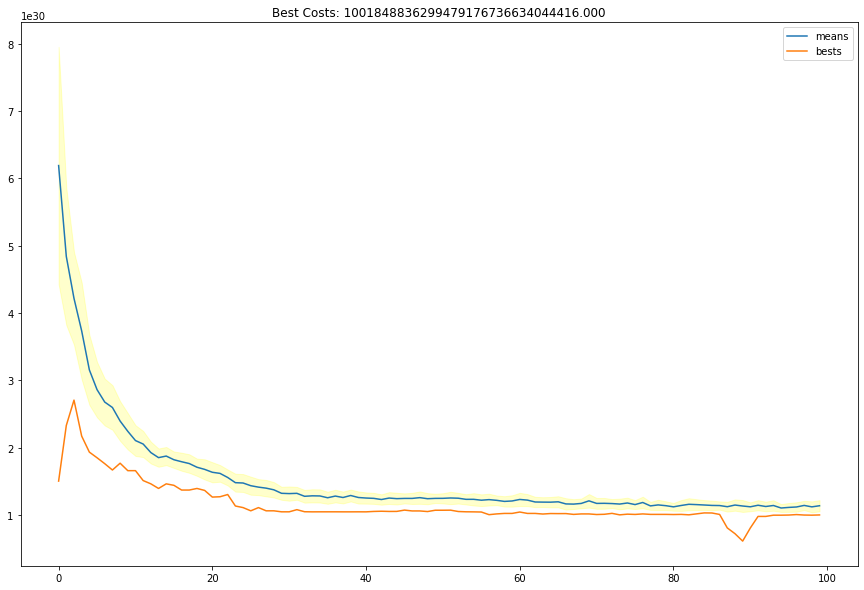

In [37]:
plotresult(best, best_costs, means, stds,min_cost)
print("La mejor organización de barcos tiene costo", min_cost, " y es la siguiente:")
for idx,barco in enumerate(best):
  print(idx,barcos[barco])



# Algortimo de enfriamiento simulado

In [38]:
def obtenerVecino(solucion):
  posicion1 =  np.random.randint(0, len( solucion) ) # tomamos un numero aleatorio entero entre 0 y la cantidad de elementos de la lista.
  
  if (posicion1 < len(solucion) - 1 ):
    posicion2 =  posicion1 + 1 # si la primera posición es menor que la cantidad de elementos de la solucion menos uno, entonces la posicion 2  es igual a la posicion uno mas uno.
  else: 
    posicion2 = 0 # sino, hacemos la posicion dos igual a cero.

  resultado = np.copy(solucion) # hacemos copia del la lista inicial.
  resultado[posicion1] = solucion[posicion2] # reemplazamos el valor de la posicion 1 de la lista resultado con el valor de la posicion 2 de la lista solucion
  resultado[posicion2] = solucion[posicion1] # reemplazamos el valor de la posicion 2 de la lista resultado con el valor de la posicion 1 de la lista solucion
  return resultado



In [39]:
def obtenerVecino(solucion):
  posicion1 =  np.random.randint(0, len( solucion) )
  
  if (posicion1 < len(solucion) - 1 ):
    posicion2 =  posicion1 + 1
  else: 
    posicion2 = 0

  resultado = np.copy(solucion)
  resultado[posicion1] = solucion[posicion2]
  resultado[posicion2] = solucion[posicion1]
  return resultado

In [40]:
def run_sa(n_individuals, n_cooling_steps, init_population_function, cost_function, generate_neighbor_function):

    pop = init_population_function(n_individuals)

    mean_costs = []
    std_costs  = []
    best_costs = []
    best_sols  = []

    min_cost = np.inf
    min_sol  = None

    for T in tqdm(np.linspace(1,0,n_cooling_steps)):
        costs = []
        for i in range(len(pop)):
            sol = pop[i]
            cost_sol = cost_function(sol)

            # generate a neighbour
            nbr = generate_neighbor_function(sol)
            cost_nbr = cost_function(nbr)

            # if the neighbour is better
            if cost_nbr<cost_sol or np.random.random()<T:
                sol = nbr
                cost_sol = cost_nbr

            pop[i] = sol
            costs.append(cost_sol)

            if cost_sol < min_cost:
                min_sol  = np.copy(pop[i])
                min_cost = cost_function(pop[i])

        best_costs.append(np.min(costs))
        mean_costs.append(np.mean(costs))
        std_costs.append(np.std(costs))

    mean_costs = np.array(mean_costs)
    std_costs  = np.array(std_costs)
    best_costs = np.array(best_costs)
    
    return min_sol, best_costs, mean_costs, std_costs,min_cost

In [ ]:
n_individuals = 100
n_cooling_steps = 1000


bestsol, bests_sa, means_sa, stds_sa,min_cost_sa = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: inicializar(x, idx_barcos), 
                                     cost_function              = lambda x: calculo(x, barcos),
                                     generate_neighbor_function = obtenerVecino)

  4%|▎         | 36/1000 [00:09<04:23,  3.66it/s]

In [ ]:
plotresult(bestsol, bests_sa, means_sa, stds_sa,min_cost_sa)

print("La mejor organización de barcos tiene costo", min_cost_sa, " y es la siguiente:")
for idx,barco in enumerate(bestsol):
  print(idx,barcos[barco])


def plot_evolution(best,bests, means, stds, min_cost):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()
    plt.title("Best Costs: %.3f"%min_cost)

def plotresult(best, bests, means, stds,min_cost):
    fig = plt.figure(figsize=(15,10))
    plot_evolution(best,bests, means, stds,min_cost)